### Use iterThreshA() algo with visual debugging of ColorCube

##### Specifically, we want to see:
 - what type of boundaries get made by the algo
 - why does it perform worse than apriori thresh?
   - becasue green isn't maxed out?
 - how to add multiple OR threshes using boosting

In [86]:
import os, sys, copy, random, pickle
sys.path.append("../")
%load_ext autoreload
%autoreload 2
import cv2
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from modules.Interproc import DBInterface
from modules.Interproc import GuiviewState
from modules.ControlTracking import TrackFactory
from modules.ControlDisplay import Display
from modules.ImgUtils import (filter_pixels_circle, crop_img)

from modules.AnalysisHelpers import ( multiPlot, colorCube,
         SubprocColorCube, subprocColorCube, buildConfusionData, 
         buildConfusionPlotData, buildRegionMarkers, confusionPlotByViews,
         confusionPlotByImage, PixelConfusionMatrix, cvtPlot,
         applyTracker, EvalTracker, presetCubeViews)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and Inspect Data

In [2]:
#Load GS data into workbook

    # these gs-states are from data/proc/tmp/dec14/output5/6.procP
    
    # subscripts: g for Green; o for Orange

    # note: these are output from an already scored video, thus the GS's 
    #       have displayInputScore and not a displayOutputScore

DATA_DIR = "../data/misc/books/iterthresha-vizdebug-1/"

db_name = "interprocGreen.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSg = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

db_name = "interprocOrange.db"
gsDb = DBInterface(os.path.join(DATA_DIR, db_name))
listGSo = [ pickle.loads(d[1]) for d in gsDb.selectAll()]

print [_gs.frameCounter for _gs in listGSg]
print [_gs.frameCounter for _gs in listGSo]

[0, 22, 40, 47, 49, 78, 84, 125, 188, 380]
[0, 9, 78, 116, 136, 176, 195, 246, 307, 340]


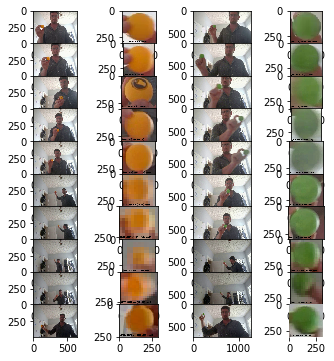

In [6]:
#View our Data
col1, col2, col3, col4 = [], [], [], []

for _gs in listGSo:
    _gs.initDisplay()
    col1.append(_gs.getOrigFrame())
    col2.append(_gs.display.scoreFrame.copy())
    
for _gs in listGSg:
    _gs.initDisplay()
    col3.append(_gs.getOrigFrame())
    col4.append(_gs.display.scoreFrame.copy())
    
#     data2.append(_gs.getZoomWindow())
chart_data = [col1, col2, col3, col4]

#concise view
multiPlot(chart_data, hspace = 0, wspace = 0, figsize = (6,6))

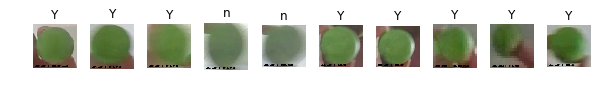

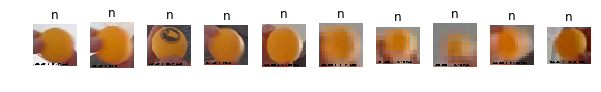

In [87]:
#View which frames of each video have successful Tracks

    #note: orange does not have a known region yet so all tracks will fail

ev = EvalTracker()
chart_legend = ["n", "Y"]

def showSuccess(_ballColor, _listGS, _listImgs):
    ''' display a plot of each scoreWindow and Y or n for trackSuccess'''

    tracker = TrackFactory(on=True)
    tracker.setInit(ballColor=_ballColor)
    tracker.setAlgoEnum(1)

    outputData = applyTracker(listGSg, tracker, bLogPlts=False)

    chart_col_title = [ chart_legend[int(ev.checkTrackSuccess(elem))] 
                          for elem in outputData['listScore']
                      ]
    chart_data = [[elem] for elem in _listImgs]

    multiPlot(chart_data
             ,input_frame_titles = chart_col_title
             ,bGrid = False
             ,bForceTitles = True
             )

showSuccess("green", copy.deepcopy(listGSg), copy.deepcopy(col4))
showSuccess("orange", copy.deepcopy(listGSo), copy.deepcopy(col2))

### Plot ColorCubes on Multiple Good Tracks vs Bad Ones

In [47]:
pcm = PixelConfusionMatrix()

In [50]:
tracker = TrackFactory(on=True)
tracker.setInit(ballColor="green")
tracker.setAlgoEnum(1)
thresh1 = (tracker.getTrackParams()['thresh_lo']
           ,tracker.getTrackParams()['thresh_hi'])
thresh1

((29, 86, 6), (64, 255, 255))

In [54]:
views1 = presetCubeViews()
view1 = views1[0][1]
view1

{'azimuth': -81, 'elevation': 95}

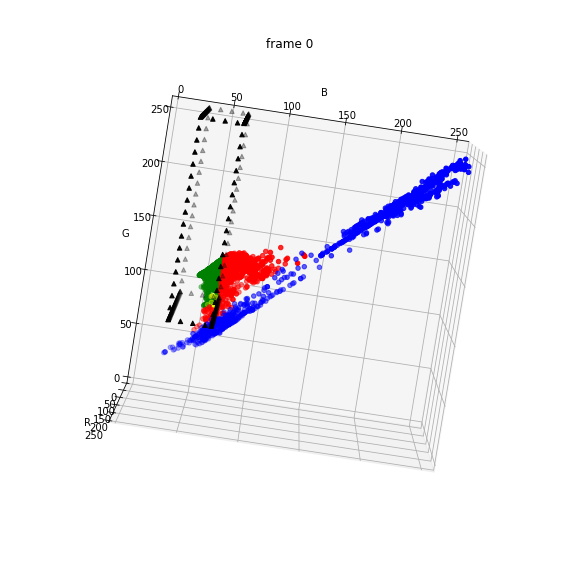

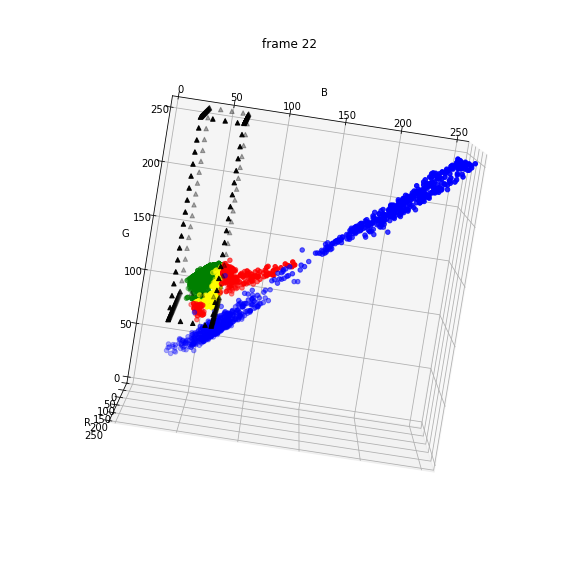

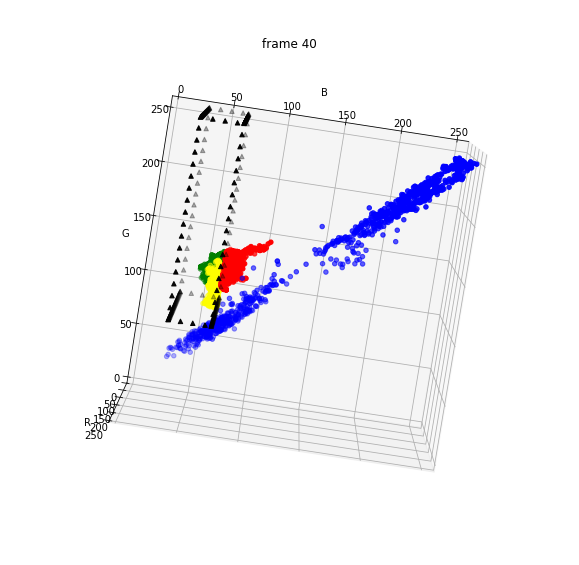

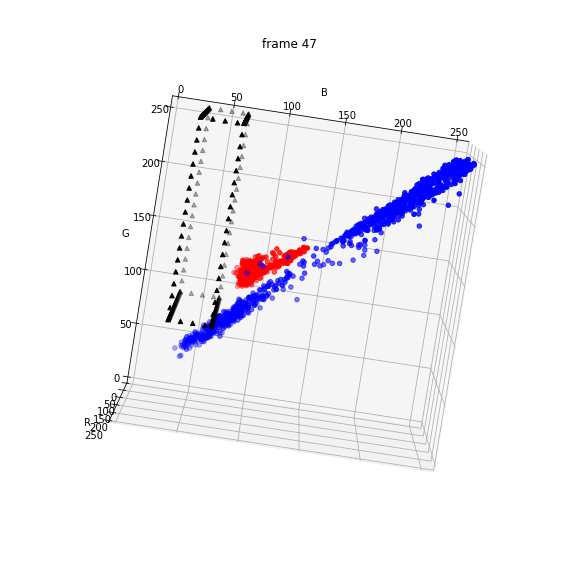

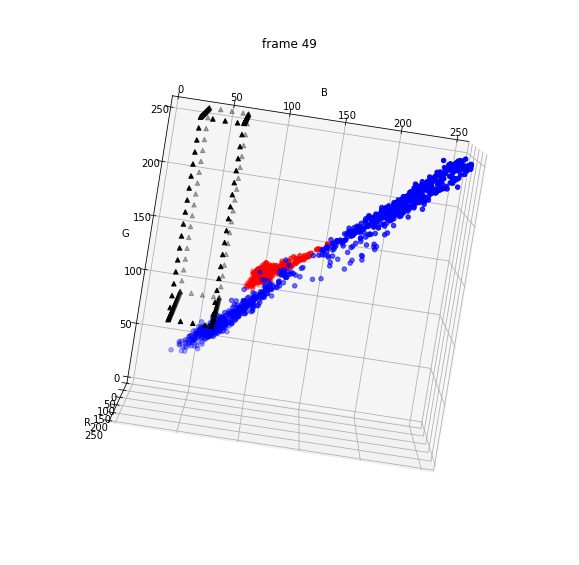

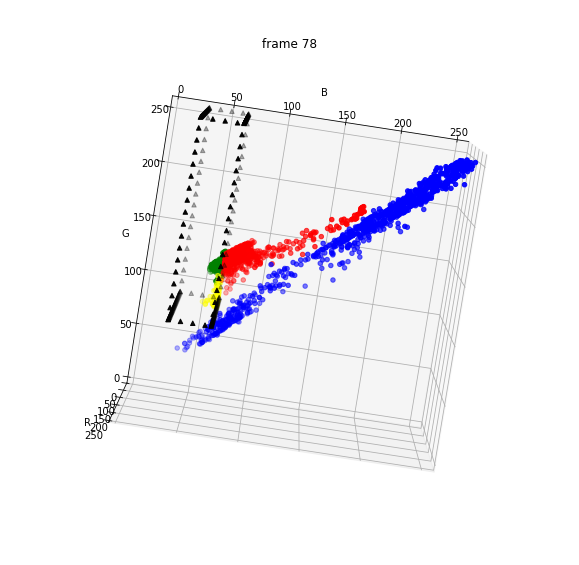

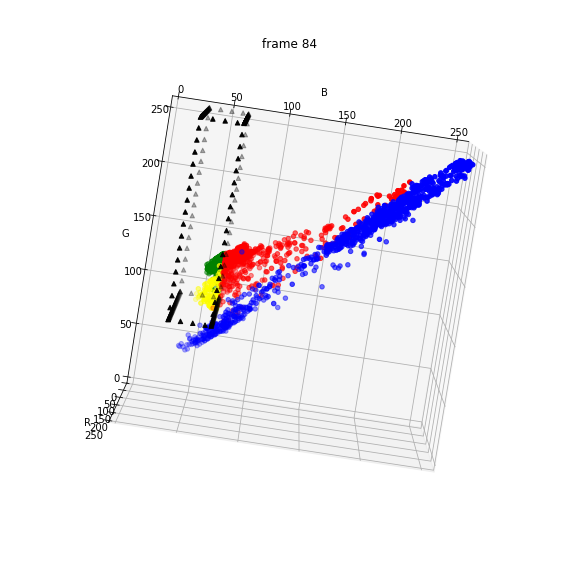

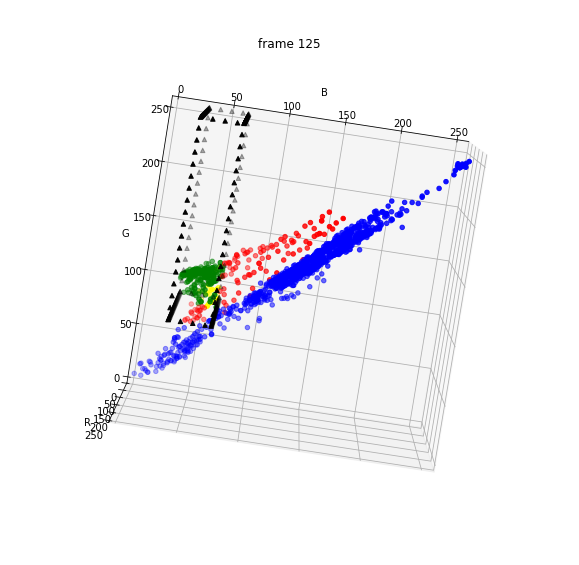

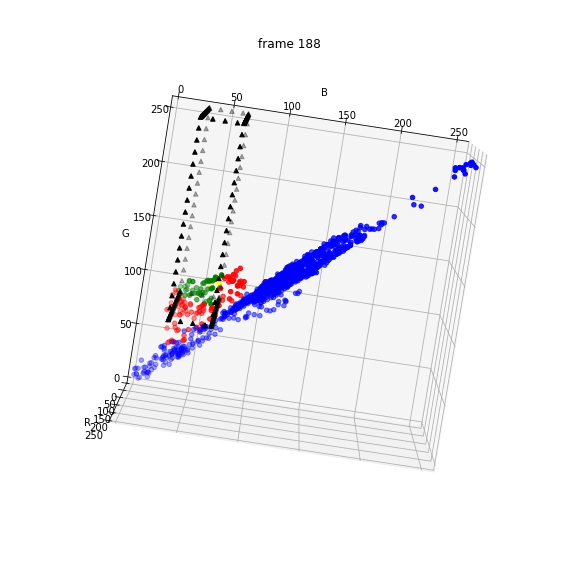

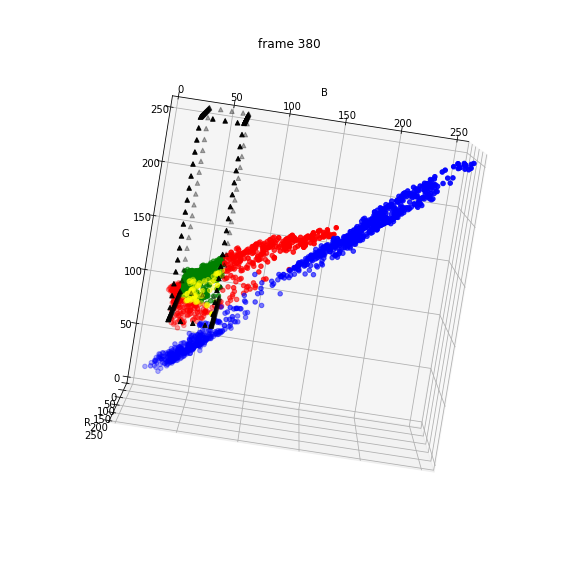

In [79]:
# green tracks

confusionPlotByImage( listGS = listGSg
                     ,inputThresh = thresh1
                     ,viewPositionDefined = view1
                     ,bOutputScore = False
                    )

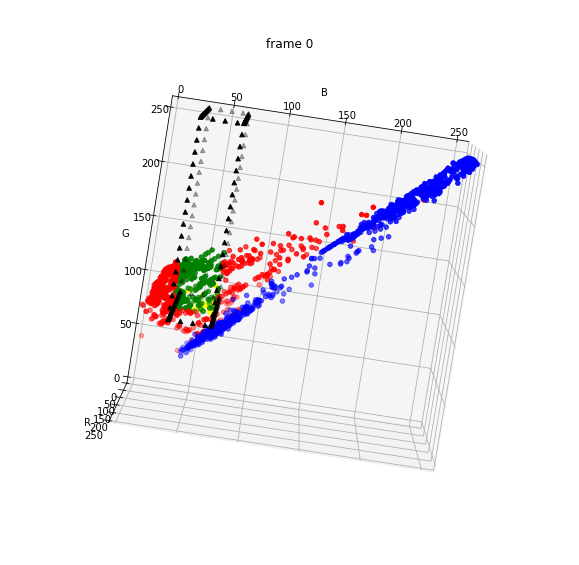

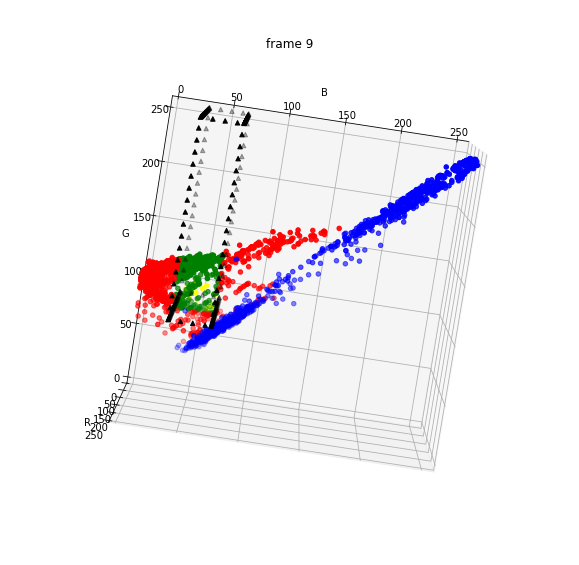

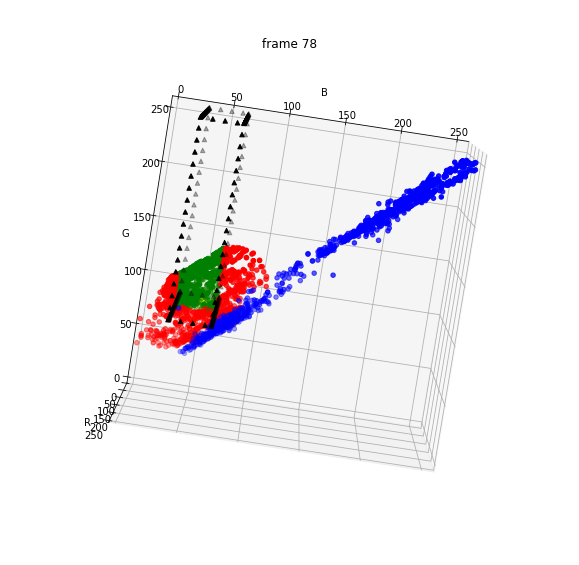

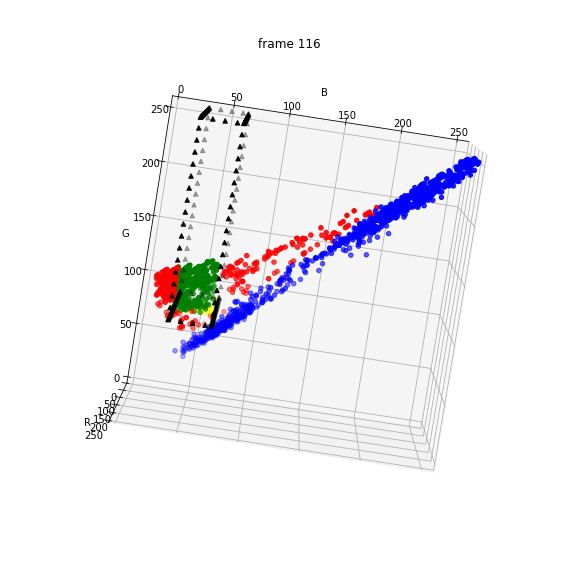

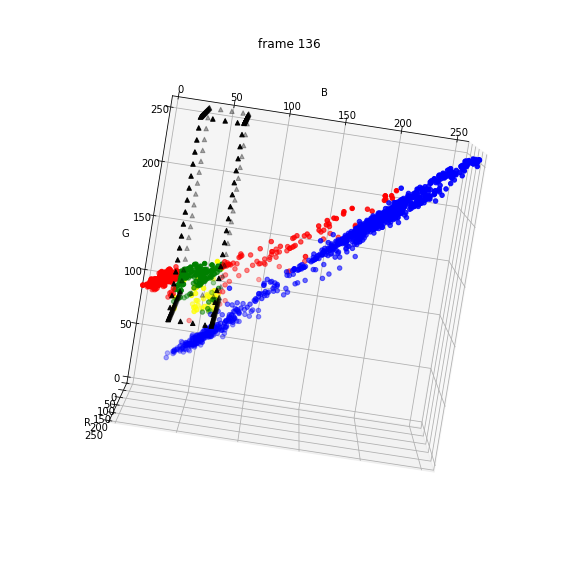

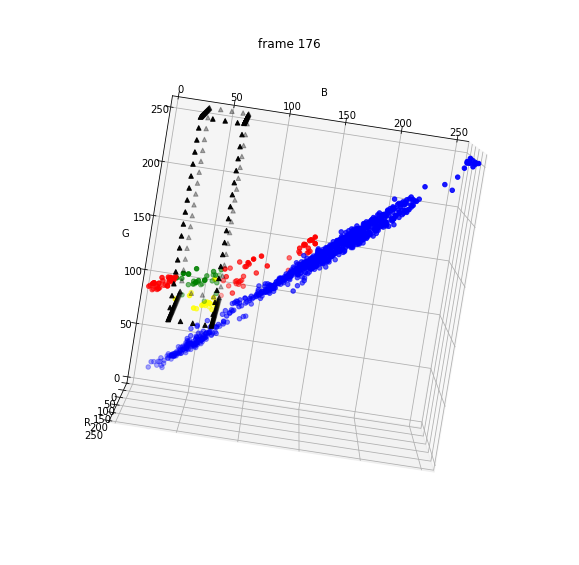

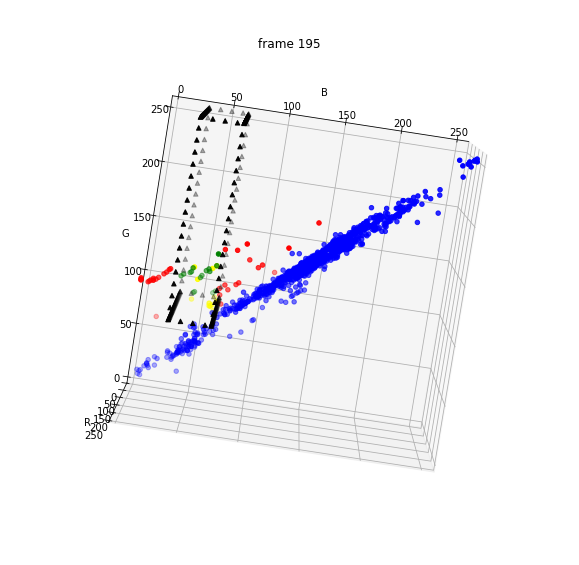

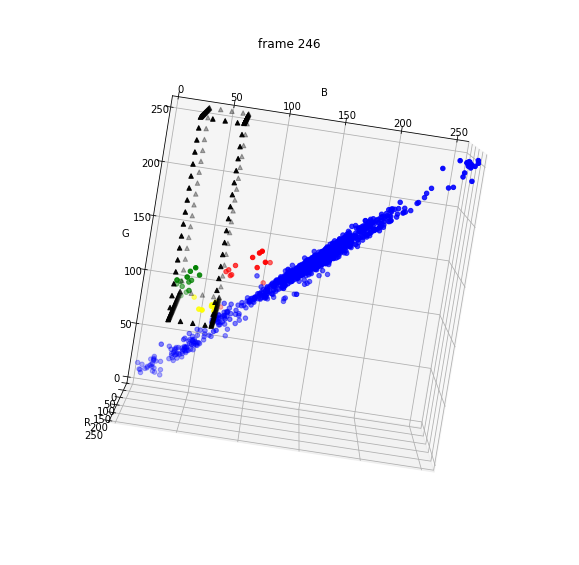

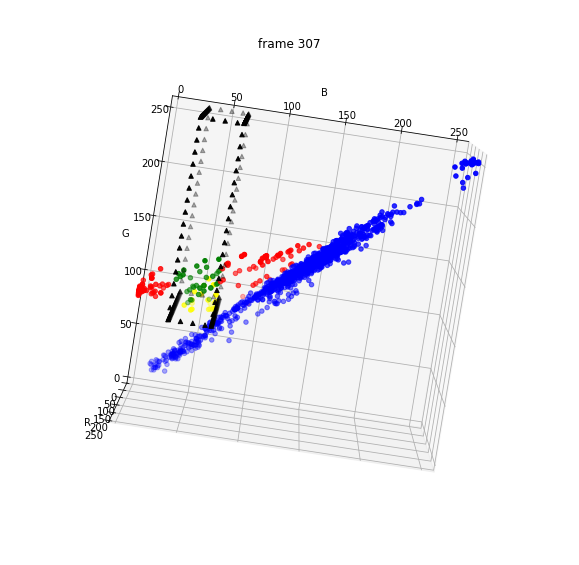

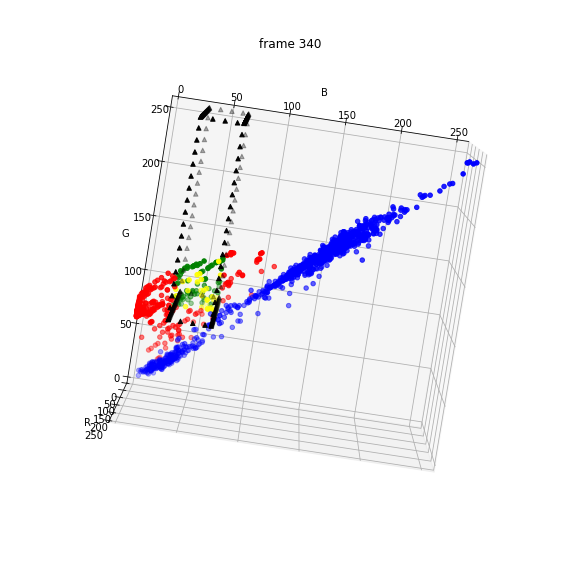

In [85]:
#orange tracks (with green thresh, still somewhat works)

confusionPlotByImage( listGS = listGSo
                     ,inputThresh = thresh1
                     ,viewPositionDefined = view1
                     ,bOutputScore = False
                    )

### Plot ColorCube Data of just the Ball

In [116]:
from modules.IterThresh import iterThreshA
from modules.AnalysisHelpers import imgToColors, pointsToList

In [89]:
_gs = listGSg[0]

In [91]:
pcm = PixelConfusionMatrix(img = _gs.getOrigFrame()
                          ,threshes = [thresh1]
                          ,circle = _gs.displayInputScore['0']['data']
                          )
pcm.calc()

In [103]:
#TODO - add "truePix" to PCM, from the circleMask
pix1 = pcm.tpPix.copy()
pix2 = pcm.fnPix.copy()
pix = np.concatenate((pix1,pix2))

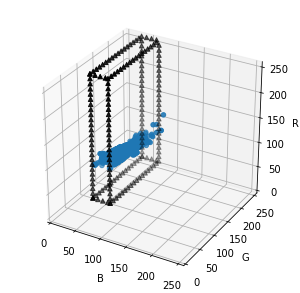

In [137]:
colorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh1]) 
          ,figsize = (5,5)
         )
subprocColorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh1]) 
         )

### Introducing iterTheshA

In [139]:
# arrange to 3-dim
pix2 = np.array(pix, dtype='uint8', ndmin = 3)
pix2.shape

#run iterThresh
outputLog = iterThreshA( pix2
                         ,goal_pct = .95
                         ,steep = False)

#parse output
thresh_out = (outputLog[1][3], outputLog[1][4])
thresh_out

([46, 83, 80], [99, 136, 120])

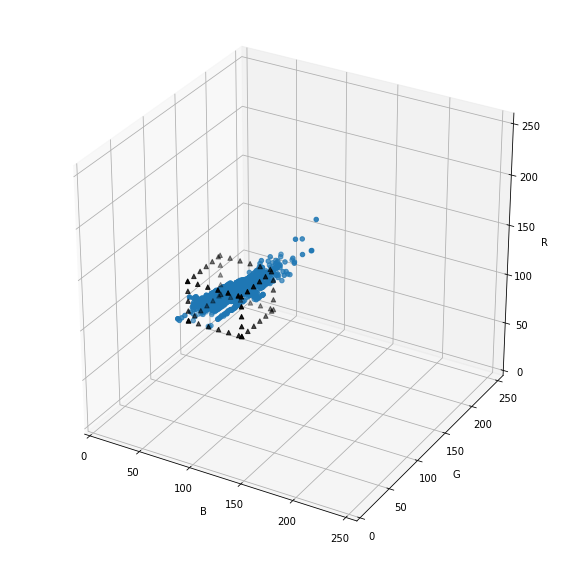

In [138]:
colorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )
subprocColorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )

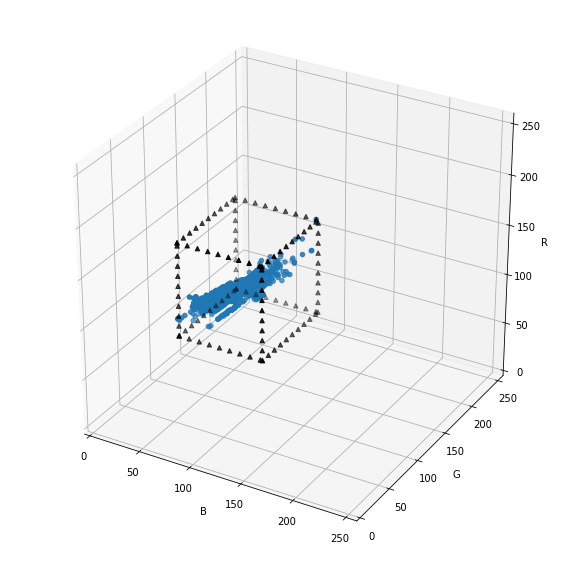

In [143]:
#SAME - but with steep=True

pix2 = np.array(pix, dtype='uint8', ndmin = 3)

outputLog = iterThreshA( pix2
                         ,goal_pct = .95
                         ,steep = True)

thresh_out = (outputLog[1][3], outputLog[1][4])

colorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )
subprocColorCube( *pointsToList(pix)
          ,regionMarkers = buildRegionMarkers([thresh_out]) 
         )


As we can see, the issue is that we constrict the region too much; we should extend max-green and max-red

In [ ]:
# TODO
#  - show stagewise progression of iterThresh
#  - show non ball data in the cube, dif colors
#  - show multiple frames having done iterThresh on same cube

### Misc

In [ ]:
ev = EvalTracker()
ev.setBaselineScore(score)
ev.checkTrackSuccess(score1)

evalDict = {}
evalDict['distance'] = ev.distanceFromBaseline(score)
evalDict['success'] = ev.checkTrackSuccess(score)
evalDict['inBaseline'] = ev.checkTrackInsideBaseline(score)
#evalDict['inWindow'] = ev.checkTrackInWindow(score)
iterLog['eval'] = evalDict

In [84]:
[_gs.displayInputScore for _gs in listGSg]

[{u'0': {u'data': [436, 320, 68, 68], u'type': u'circle'},
  u'1': {u'data': [442, 324, 60, 62], u'type': u'circle'}},
 {u'0': {u'data': [152, 240, 92, 96], u'type': u'circle'},
  u'1': {u'data': [150, 248, 90, 82], u'type': u'circle'}},
 {u'0': {u'data': [528, 208, 94, 94], u'type': u'circle'},
  u'1': {u'data': [534, 214, 78, 82], u'type': u'circle'}},
 {u'0': {u'data': [1018, 182, 92, 100], u'type': u'circle'},
  u'1': {u'data': [1020, 194, 86, 78], u'type': u'circle'}},
 {u'0': {u'data': [1122, 194, 110, 104], u'type': u'circle'},
  u'1': {u'data': [1128, 202, 96, 90], u'type': u'circle'}},
 {u'0': {u'data': [742, 358, 80, 78], u'type': u'circle'},
  u'1': {u'data': [752, 364, 68, 68], u'type': u'circle'}},
 {u'0': {u'data': [682, 404, 72, 68], u'type': u'circle'},
  u'1': {u'data': [688, 410, 60, 58], u'type': u'circle'}},
 {u'0': {u'data': [678, 480, 22, 22], u'type': u'circle'},
  u'1': {u'data': [680, 482, 18, 18], u'type': u'circle'}},
 {u'0': {u'data': [600, 458, 14, 14], u't